In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, make_scorer, mean_squared_error
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, \
StratifiedKFold, learning_curve, KFold, GridSearchCV

import xgboost as xgb
from sklearn.neighbors import NearestNeighbors


import warnings
warnings.filterwarnings("ignore")

from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

import shap

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from scipy.stats import zscore



# Data Preparation

## Classification

Membaca data

In [ ]:
data2 = pd.read_csv('data.csv')
data1 = pd.read_csv('data1.csv')

Menghandling Outlier

In [ ]:
data2 = data2[
        (data2['Tekanan darah  (S)'] < 160) &
        (data2['Berat badan (kg)'] < 125) &
        (data2['IMT (kg/m2)'] < 40 ) &
        (data2['Glukosa Puasa (mg/dL)'] < 200) &
        (data2['Trigliserida (mg/dL)'] < 500)
        ]

Meng-encoding Jenis Kelamin

In [ ]:
data2['Jenis Kelamin'] = data2['Jenis Kelamin'].map({'F': 0, 'M': 1})
data1['Jenis Kelamin'] = data1['Jenis Kelamin'].map({'F': 0, 'M': 1})

Menyeleksi fitur

In [ ]:
data2 = data2.drop(['Tempat lahir','Tinggi badan (cm)', 'Berat badan (kg)', 'Responden'], axis=1)
data1 = data1.drop(['Tinggi badan (cm)', 'Berat badan (kg)', 'Responden'], axis=1)

Function untuk menampilkan Learning Curve

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


Uncomment dan run cell dibawah untuk menjalankan data preparation untuk model klasifikasi

Tambahan feature engineering untuk klasifikasi. Membuat kolom baru `cholesterol` berdasar kolom `Cholesterol Total (mg/dL)`

In [ ]:
data2['cholesterol'] = data2['Cholesterol Total (mg/dL)'] >= 200
data2['cholesterol'] = data2['cholesterol'].replace([True, False], [1, 0])

data1['cholesterol'] = data1['Cholesterol Total (mg/dL)'] >= 200
data1['cholesterol'] = data1['cholesterol'].replace([True, False], [1, 0])

Tambahan meng-handling outlier untuk klasifikasi

In [ ]:
outliers1 = data2[(data2['Lingkar perut (cm)'] == np.min(data2['Lingkar perut (cm)'])) & (data2['cholesterol'] == 1)]
data2 = data2.drop(outliers1.index)

Tambahan Feature Engineering Usia IMT/BMIuntuk klasifikasi

In [ ]:
age_ranges = [(0, 20), (21, 35), (36, 50), (51, 65)]

bmi_categories = [ ('IMT Kurang', lambda x : x < 18.5), ('IMT Normal', lambda x: 18.5 <= x < 25), ('IMT Gemuk', lambda x: 25 <= x < 30), ('IMT Obesitas', lambda x: x >= 30) ]

def encode_age(age):
    for i, age_range in enumerate(age_ranges):
        if age_range[0] <= age <= age_range[1]:
            return i
    return None

def encode_bmi(bmi):
    for i, (category, condition) in enumerate(bmi_categories):
        if condition(bmi):
            return i
    return None

data2['Usia'] = data2['Usia'].apply(encode_age)
data1['Usia'] = data1['Usia'].apply(encode_age)

data2['IMT (kg/m2)'] = data2['IMT (kg/m2)'].apply(encode_bmi)
data1['IMT (kg/m2)'] = data1['IMT (kg/m2)'].apply(encode_bmi)

## Data Splitting

### Data 2

In [ ]:
X1 = data2.drop(columns = ['Cholesterol Total (mg/dL)', 'cholesterol'])
y = data2['cholesterol']

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)



Transformasi kolom `Fat` dan `Visceral Fat`

In [ ]:
mode_value = X_train['Visceral Fat'].mode()[0]
X_train.loc[X_train['Visceral Fat'] == mode_value, 'Visceral Fat']= np.nan

mode_values = X_train['Fat'].mode()[0]
X_train.loc[X_train['Fat'] == mode_values,'Fat']=np.nan


class PandasColumnPreserver(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)

pipeline = make_pipeline(
    StandardScaler(),
    KNNImputer(n_neighbors=3),
    PandasColumnPreserver(columns=X_train.columns)  # Add custom transformer to preserve column names
)

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)


### Data 1

In [ ]:
X = data1.drop(columns = ['Cholesterol Total (mg/dL)', 'cholesterol'])
y = data1['cholesterol']

Transformasi kolom `Fat` dan `Visceral Fat`

In [ ]:
X_transformed = pipeline.transform(X)

## Regresssion

### Data 2

In [ ]:
data2 = pd.read_csv('data.csv')
data1 = pd.read_csv('data1.csv')

Boxplot fitur pada data 2

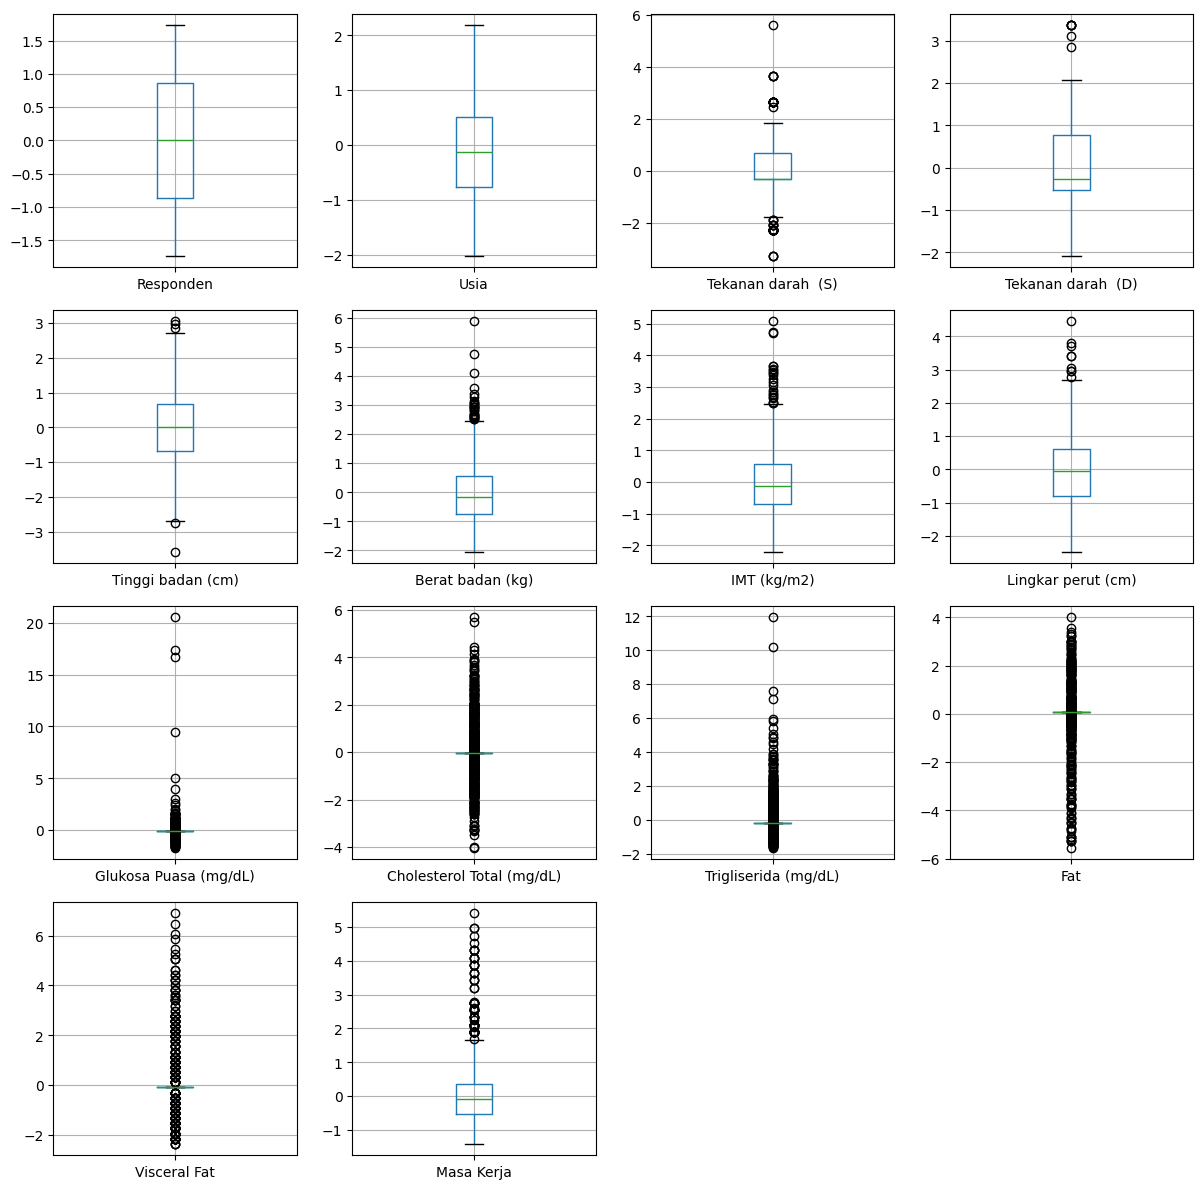

In [ ]:
df_numeric = data2.select_dtypes(include=['float64', 'int64'])

# Standardize the data with z-score
df_numeric = df_numeric.apply(zscore)

# Determine the number of rows and columns for the subplot grid
n = len(df_numeric.columns)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*3))

# Flatten the 2D array to 1D array of axes
axes = axes.ravel()

for i, column in enumerate(df_numeric):
    df_numeric.boxplot(column, ax=axes[i])

# Remove empty subplots
if n < nrows*ncols:
    for j in range(i+1, nrows*ncols):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
data2 = data2[(data2['Tekanan darah  (S)'] < 160) & (data2['Berat badan (kg)'] < 125) & (data2['IMT (kg/m2)'] < 40 ) & (data2['Glukosa Puasa (mg/dL)'] < 200) & (data2['Trigliserida (mg/dL)'] < 500)]

data2.drop(['Responden','Tempat lahir'], axis=1, inplace=True)
data2.drop(columns=['Tinggi badan (cm)', 'Berat badan (kg)'], inplace=True)

data2['Jenis Kelamin'] = data2['Jenis Kelamin'].map({'F': 0, 'M': 1})

data2.reset_index(drop=True, inplace=True)

#Quick transformation on data1
data1['Jenis Kelamin'] = data1['Jenis Kelamin'].map({'F': 0, 'M': 1})
data1.reset_index(drop=True, inplace=True)

data1.drop(['Responden'], axis=1, inplace=True)
data1.drop(columns=['Tinggi badan (cm)', 'Berat badan (kg)'], inplace=True)


Mengedrop duplicate Cholesterol total dengan nilai modus (187)

In [ ]:
# Get the mode
mode_value = data2['Cholesterol Total (mg/dL)'].mode()[0]

# Get the indices of the rows where 'Cholesterol Total' is equal to the mode
indices = data2[data2['Cholesterol Total (mg/dL)'] == mode_value].index

# If there are more than 10 such rows, drop all but 10 of them
if len(indices) > 20:
    # Keep the first 10 indices and drop the rest
    data2 = data2.drop(indices[20:])

# Reset the index
data2 = data2.reset_index(drop=True)

Boxplot fitur pada data 2 setelah preparation

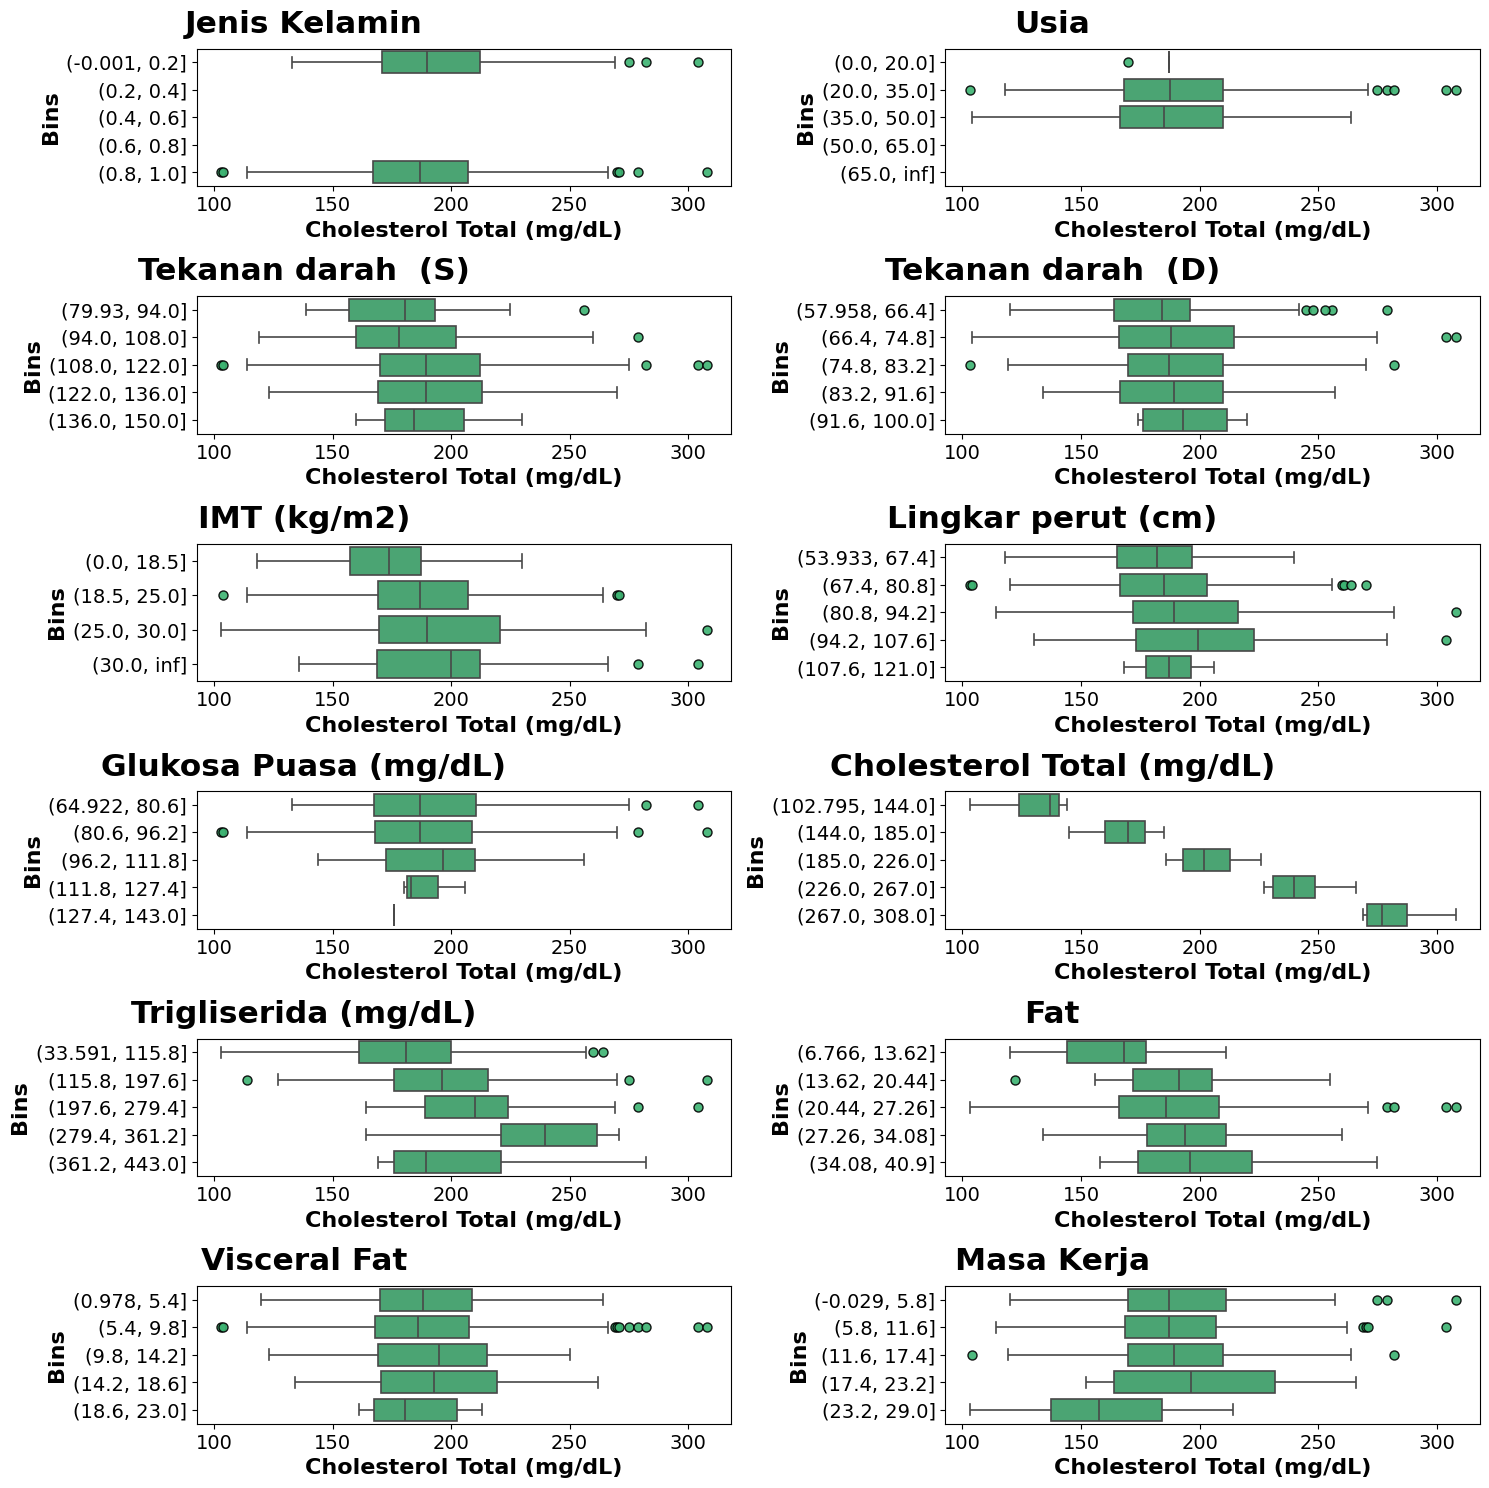

In [ ]:
df=data2.copy()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_box(ax, df, x, y, xlabel, ylabel, title, color, title_position, order=None):
    sns.boxplot(data = df, y = y, x = x, order = order,
                linewidth = 1.2, color = color,
                flierprops = dict(marker = 'o', markeredgecolor = 'black', markersize = 6.5, linestyle = 'none', markerfacecolor = color, alpha = 0.9),
                ax=ax)

    ax.set_xlabel(xlabel, fontweight = 'bold', fontsize = 16)
    ax.set_ylabel(ylabel, fontweight = 'bold', fontsize = 16)
    ax.tick_params(labelsize = 14)
    ax.text(x = title_position, y = 1.07, s = title, fontsize = 22.5, weight = 'bold', ha = 'center', va = 'bottom', transform = ax.transAxes)

# Define the bins
usia_bins = [0, 20, 35, 50, 65, np.inf]
imt_bins = [0, 18.5, 25, 30, np.inf]

# Create new binned columns
df['Usia_binned'] = pd.cut(df['Usia'], bins=usia_bins)
df['IMT_binned'] = pd.cut(df['IMT (kg/m2)'], bins=imt_bins)

# Assuming df is your DataFrame
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
n = len(num_cols)
ncols = 2
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

for ax, col in zip(axes.flatten(), num_cols):
    if col == 'Usia':
        plot_box(ax, df, x = "Cholesterol Total (mg/dL)", y = "Usia_binned", xlabel = "Cholesterol Total (mg/dL)", ylabel = "Bins", title = col, color = "mediumseagreen", title_position = 0.2)
    elif col == 'IMT (kg/m2)':
        plot_box(ax, df, x = "Cholesterol Total (mg/dL)", y = "IMT_binned", xlabel = "Cholesterol Total (mg/dL)", ylabel = "Bins", title = col, color = "mediumseagreen", title_position = 0.2)
    else:
        df['binned'] = pd.cut(df[col], bins=5)
        plot_box(ax, df, x = "Cholesterol Total (mg/dL)", y = "binned", xlabel = "Cholesterol Total (mg/dL)", ylabel = "Bins", title = col, color = "mediumseagreen", title_position = 0.2)
        df = df.drop(columns=['binned'])

# Remove any unused subplots
for ax in axes.flatten()[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

# Modelling

## Classification

### Logistic Regression

Uncomment dan run cell dibawah ini untuk menjalankan model Logistic Regression

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import f1_score
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV

# model = LogisticRegression(max_iter = 10000, random_state=42)

# param_grid = {
#     'penalty': ['l1', 'l2'],
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'saga']
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
# grid_search.fit(X_train_transformed, y_train)


# print("Best parameters found: ", grid_search.best_params_)

# best_model = LogisticRegression(**grid_search.best_params_, max_iter = 10000, random_state=42)
# best_model.fit(X_train_transformed, y_train)

# cv_scores = cross_val_score(best_model, X_train_transformed, y_train, cv=5, scoring='f1')

# print("Cross-validation scores:", cv_scores)
# print("Mean cross-validation score:", cv_scores.mean())

# print('')
# print('')

# y_pred_train = best_model.predict(X_train_transformed)

# conf_mat_train = confusion_matrix(y_train, y_pred_train)
# print("Confusion matrix on train set:\n", conf_mat_train)

# recall_train = recall_score(y_train, y_pred_train)
# print("Recall on train set: ", recall_train)

# precision_train = precision_score(y_train, y_pred_train)
# print("Precision on train set: ", precision_train)

# accuracy_train = f1_score(y_train, y_pred_train)
# print("F1 on train set: ", accuracy_train)

# print('')
# print('')

# y_pred = best_model.predict(X_test_transformed)

# conf_mat = confusion_matrix(y_test, y_pred)
# print("Confusion matrix on test set:\n", conf_mat)

# recall = recall_score(y_test, y_pred)
# print("Recall on test set: ", recall)

# precision = precision_score(y_test, y_pred)
# print("Precision on test set: ", precision)

# accuracy = f1_score(y_test, y_pred)
# print("F1 on test set: ", accuracy)

# print('')
# print('')

# y_pred = best_model.predict(X_transformed)

# conf_mat = confusion_matrix(y, y_pred)
# print("Confusion matrix on data 1:\n", conf_mat)

# recall = recall_score(y, y_pred)
# print("Recall on data 1: ", recall)

# precision = precision_score(y, y_pred)
# print("Precision on data 1: ", precision)

# accuracy = f1_score(y, y_pred)
# print("F1 on data 1: ", accuracy)

Learning Curve

In [ ]:
# plot_learning_curve(best_model, "Learning Curve", X_train_transformed, y_train, cv=5, n_jobs=-1)
# plt.show()

Shap

In [ ]:
# explainer = shap.Explainer(best_model, X_train_transformed)

# shap_values = explainer.shap_values(X_train_transformed)

# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0, :])
# shap.summary_plot(shap_values, X_train_transformed)

### XGBoost Classification

Uncomment dan run cell dibawah ini untuk menjalankan model XGBoost Classification

In [ ]:
# xgb_classifier = xgb.XGBClassifier(
#     objective='binary:logistic',
#     learning_rate=0.01,
#     scale_pos_weight=70,
#     n_estimators=500,
#     max_depth=5,
#     min_child_weight=0.01,
#     gamma=0,
#     subsample=0.6,
#     colsample_bytree=0.5,
#     reg_alpha=0.5,
#     reg_lambda=1.5,
#     random_state=42
# )

# xgb_classifier.fit(X_train_transformed, y_train)



# y_pred_train = xgb_classifier.predict(X_train_transformed)

# conf_mat_train = confusion_matrix(y_train, y_pred_train)
# print("Confusion matrix on train set:\n", conf_mat_train)

# recall_train = recall_score(y_train, y_pred_train)
# print("Recall on train set: ", recall_train)

# precision_train = precision_score(y_train, y_pred_train)
# print("Precision on train set: ", precision_train)

# accuracy_train = f1_score(y_train, y_pred_train)
# print("F1 on train set: ", accuracy_train)

# print('')
# print('')

# y_pred = xgb_classifier.predict(X_test_transformed)

# conf_mat = confusion_matrix(y_test, y_pred)
# print("Confusion matrix on test set:\n", conf_mat)

# recall = recall_score(y_test, y_pred)
# print("Recall on test set: ", recall)

# precision = precision_score(y_test, y_pred)
# print("Precision on test set: ", precision)

# accuracy = f1_score(y_test, y_pred)
# print("F1 on test set: ", accuracy)

# print('')
# print('')

# y_pred = xgb_classifier.predict(X_transformed)

# conf_mat = confusion_matrix(y, y_pred)
# print("Confusion matrix on data 1:\n", conf_mat)

# recall = recall_score(y, y_pred)
# print("Recall on data 1: ", recall)

# precision = precision_score(y, y_pred)
# print("Precision on data 1: ", precision)

# accuracy = f1_score(y, y_pred)
# print("F1 on data 1: ", accuracy)

## Regression

XGBoost

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from math import sqrt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV



X = data2.drop(columns = ['Cholesterol Total (mg/dL)'])
y = data2['Cholesterol Total (mg/dL)']

X1 = data1.drop('Cholesterol Total (mg/dL)', axis=1)
y1 = data1['Cholesterol Total (mg/dL)']

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

class CustomNullifier(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        self.mode_values_ = {column: X[column].mode()[0] for column in self.columns}
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column, mode_value in self.mode_values_.items():
            X_copy.loc[X_copy[column] == mode_value, column] = np.nan
        return pd.DataFrame(X_copy, columns=X.columns)

class DataFrameStandardScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.scaler = StandardScaler().fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(self.scaler.transform(X), columns=X.columns)

class DataFrameKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y=None):
        self.imputer = KNNImputer(n_neighbors=self.n_neighbors).fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(self.imputer.transform(X), columns=X.columns)

columns = ['Visceral Fat', 'Fat']

pipeline = Pipeline([
    ('nullifier', CustomNullifier(columns)),
    ('scaler', DataFrameStandardScaler()),
    ('imputer', DataFrameKNNImputer()),
    ('model', XGBRegressor())
])


param_grid = {
    'imputer__n_neighbors': [3],
    'model__n_estimators': [500],
    'model__learning_rate': [0.01],
    'model__scale_pos_weight': [3],
}
grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5, scoring=rmse_scorer, n_iter=100, random_state=42)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("Best model:", best_model)
print("Parameters of the best model:", best_model.get_params())
print("Test accuracy from CV scoring: ", grid_search.best_score_)

predictions = best_model.predict(X)

rmse_score = rmse(y, predictions)
print("RMSE score of the best model:", rmse_score)

Best model: Pipeline(steps=[('nullifier', CustomNullifier(columns=['Visceral Fat', 'Fat'])),
                ('scaler', DataFrameStandardScaler()),
                ('imputer', DataFrameKNNImputer(n_neighbors=3)),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorica...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
              

Plot Regresi

Data 2

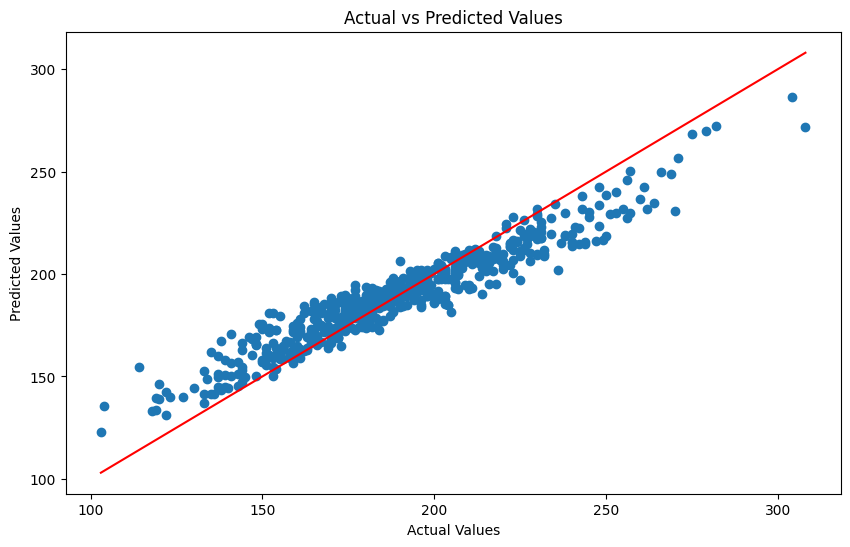

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red')  # Diagonal line
plt.show()

Data 1

Feature Importance

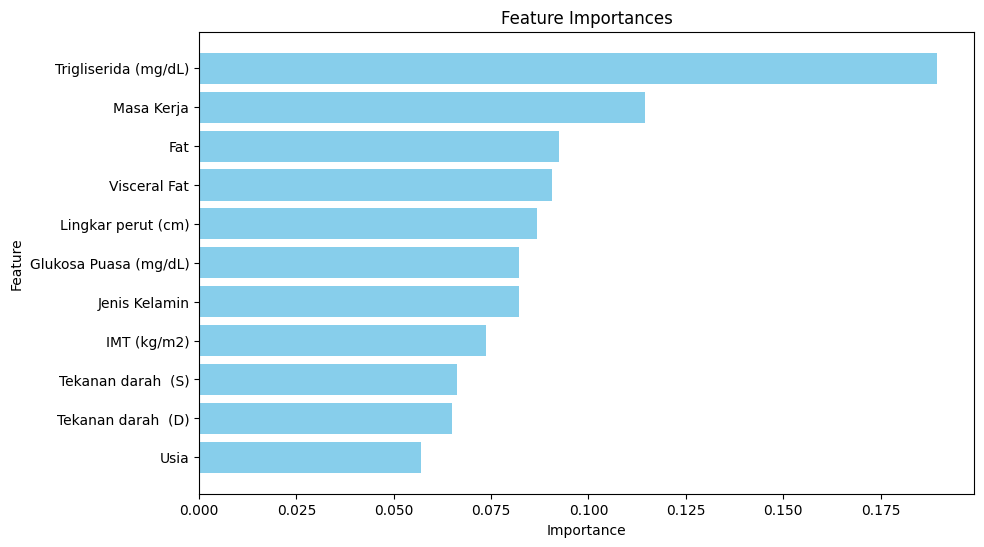

In [ ]:

fitted_model = best_model.named_steps['model']
importances = fitted_model.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

Learning Curve

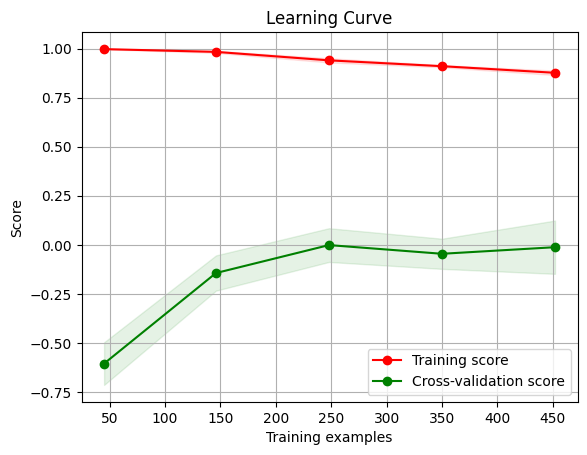

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

Shap

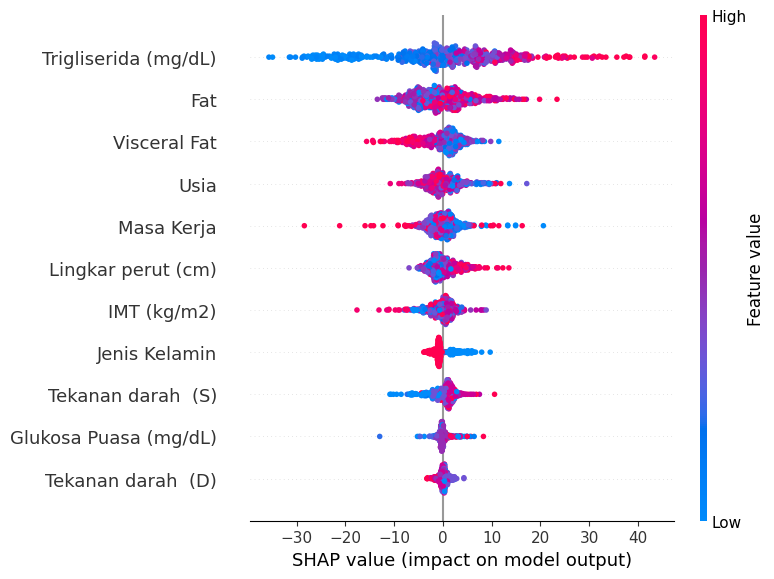

In [ ]:
X_processed = best_model.named_steps['nullifier'].transform(X)
X_processed = best_model.named_steps['scaler'].transform(X_processed)
X_processed = best_model.named_steps['imputer'].transform(X_processed)

explainer = shap.Explainer(best_model.named_steps['model'])

shap_values = explainer(X_processed)
shap.summary_plot(shap_values, X_processed)

Meskipun kami menggunakan pendekatan regresi, kami juga mengadaptasi hasil prediksi agar dapat diketahui evaluasi metrics klasifikasinya

In [ ]:

best_model.fit(X, y)

predictions = best_model.predict(X)

predictions_bin = (predictions >= 200).astype(int)

y_bin = (y >= 200).astype(int)

f1_score2 = f1_score(y_bin, predictions_bin)
print("F1 score of the best model on data2:", f1_score2)

predictions1 = best_model.predict(X1)

predictions1_bin = (predictions1 >= 200).astype(int)

if 'Cholesterol Total (mg/dL)' in data1.columns:
    y1_bin = (y1 >= 200).astype(int)

    f1_score1 = f1_score(y1_bin, predictions1_bin)
    print("F1 score of the best model on data1:", f1_score1)

    rmse_score1 = rmse(y1, predictions1)
    print("RMSE score of the best model on data1:", rmse_score1)

F1 score of the best model on data2: 0.8846153846153846
F1 score of the best model on data1: 0.5369649805447471
RMSE score of the best model on data1: 30.452187269299262


Confusion Matrix

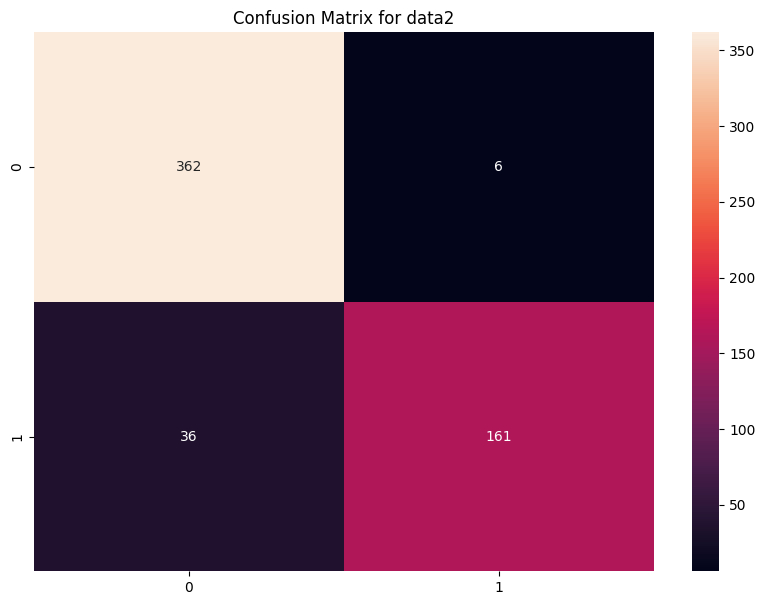

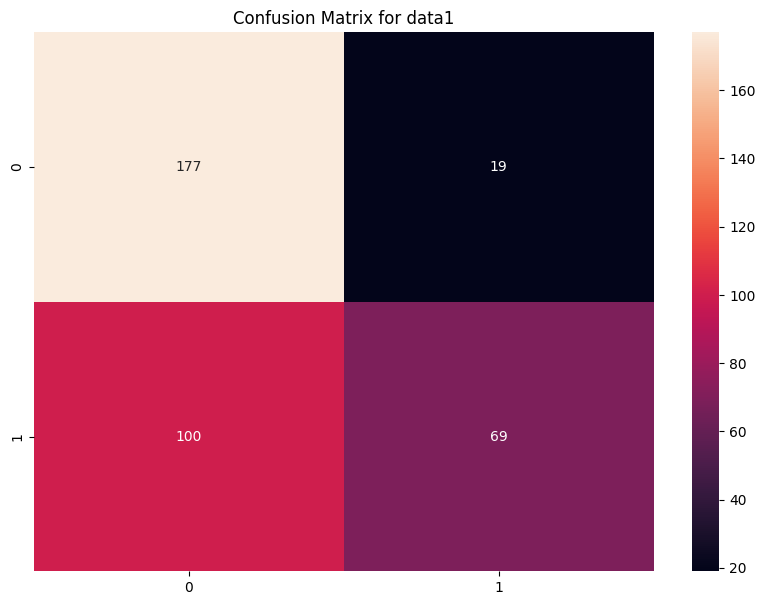

In [ ]:
cm2 = confusion_matrix(y_bin, predictions_bin)
cm1 = confusion_matrix(y1_bin, predictions1_bin) if 'Cholesterol Total (mg/dL)' in data1.columns else None

plt.figure(figsize=(10,7))
plt.title('Confusion Matrix for data2')
sns.heatmap(cm2, annot=True, fmt='d')
plt.show()

if cm1 is not None:
    plt.figure(figsize=(10,7))
    plt.title('Confusion Matrix for data1')
    sns.heatmap(cm1, annot=True, fmt='d')
    plt.show()

Plot regresi data 1

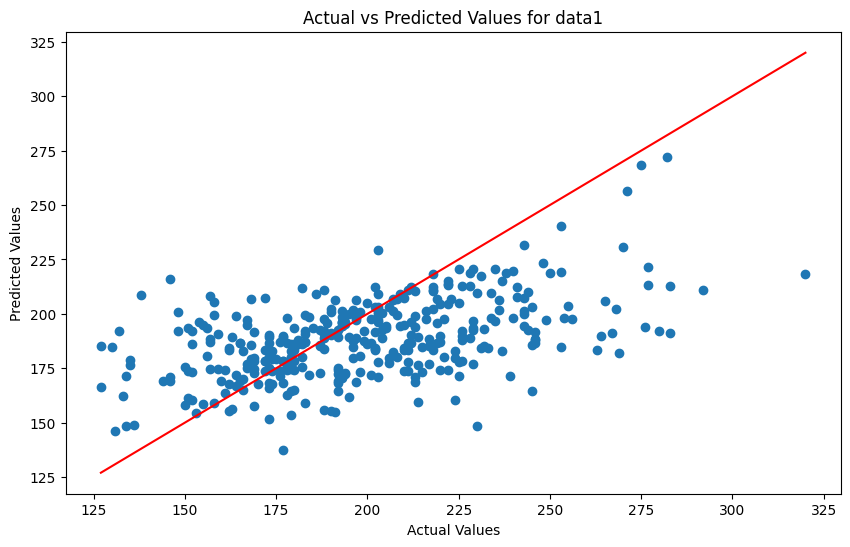

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y1, predictions1)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for data1')
plt.plot([min(y1), max(y1)], [min(y1), max(y1)], color='red')  # Diagonal line
plt.show()

Tambahan: Kode untuk is_urban

-------

In [ ]:
from fuzzywuzzy import fuzz, process
data2["Tempat lahir"] = data2["Tempat lahir"].str.lower()
tempat_lahir = data2["Tempat lahir"].unique()
final_tempat = []

for tempat in tempat_lahir:
    if not final_tempat:  # This checks if final_tempat is empty
        final_tempat.append(tempat)
    else:
        # Use a flag to track if tempat is similar to any element in final_tempat
        is_similar = False
        for tempat2 in final_tempat:
            if fuzz.ratio(tempat2, tempat) > 80:
                print("Dropped: ", tempat)
                is_similar = True
                break  # No need to check the rest, so break the loop
        if not is_similar:  # If tempat is not similar to any element in final_tempat, append it
            final_tempat.append(tempat)

final_tempat.append("malang")
final_tempat.append("serang")
final_tempat.append("purwakarta")
final_tempat.append("ujung pandang")
final_tempat.append("ujung batu")

final_tempat = sorted(final_tempat)

print(final_tempat)

In [ ]:
def get_closest_match(x):
    return process.extractOne(x, final_tempat)[0]

data2['Tempat lahir'] = data2['Tempat lahir'].apply(get_closest_match)

In [ ]:
urban=['balipapan','bandung','banjarmasin','banten','bantul','banyumas','batam','bekasi','blora','bogor','boyolali','brebes','bukittinggi','ciamis','cianjur','cilacap','cimahi','cirebon','depok','garut','gresik','grobogan','indramayu','jakarta','jakarta utara','jayapura','jepara','kab. semarang','karanganyar','karawang','kebumen','kendal','klaten','kota administrasi jakarta pusat','kudus','kuningan','lamongan','magelang','majalengka','makassar','malang','manado','maros','mataram','medan','padang','padang panjang','palembang','pasuruan','pati','pekalongan','pekanbaru','pemalang','purbalingga','purwakarta','purworejo','salatiga','samarinda','semarang','serang','sidoarjo','sleman','solo','sragen','subang','sukabumi','sukoharjo','sumedang','surabaya','surakarta','tangerang','tanjung pinang','tasikmalaya','tegal','temanggung','wonogiri','wonosobo','yogyakarta']

In [ ]:
data2['is_urban'] = data2['Tempat lahir'].isin(urban)

In [ ]:
data2['is_urban'].to_csv('is_urban.csv', index=False)

-----